In [1]:
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, accuracy_score, log_loss
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

In [2]:
(X, Y), (X_test, Y_test) = fashion_mnist.load_data()
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

### Normalization and preprocessing
Feature values range between 0-255, therefore normalizing is as trivial as ddividing by 255

    Also images are consistent in the way they are captured by the camera, lighting, rotation etc. Therefore no preprocessing or data generation is necessary. Simply reshaping the dataset into a shape that a convolutional layer can process is enough.

In [3]:
# normalize features
x_train = X_train.astype('float')
x_val = X_val.astype('float')
x_test = X_test.astype('float')
x_train  /= 255
x_val /= 255
x_test  /= 255
# reshape features into width * height * color channel, color_channel is 1 since all images in dataset are grayscaled
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_val = x_val.reshape(x_val.shape[0], 28, 28, 1)
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)

In [4]:
y_train = to_categorical(Y_train, 10)
y_val = to_categorical(Y_val , 10)
y_test = to_categorical(Y_test, 10)

### Model
My strategy to increase model performance was to learn from training data as much as possible, without overfitting.
Deep networks, due to the large quantity of neurons, usually overfits on the training data if no precaution is taken

Therefore, I investigated the amount of overfitting using a loss vs epochs and accuracy vs epochs plots for both training and validation sets on top of each other. My aim was to control the amount of training data fit so that training and validation loss (and accuracy) converge (follow the same trend and have almost the same values over epochs).

If the validation loss surpasses training loss and keeps diverging from training loss, that means the model is overfitting. In such cases I reduce overfitting by either increasing Dropout rates, or decreasing amount of neurons, either in a convolutional layer or a dense layer.

If the validation loss and training loss follow a very similar trend over epochs, but validation loss is lower than training, that means that the model can learn more from the training data, without loss of generality. 

Other than the overfitting issue, I have both read about the benefits of chaining multiple convolutional layers before a pooling layer, and tried myself. Due to the simplicity of the problem, having more than 3 convolutional layers caused overfitting, and therefore impacted performance negatively. However chaining the last 2 convolutional layers, without a pooling layer in between caused a slight gain in performance.

In [5]:
model = Sequential()
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', input_shape=x_train.shape[1:]))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.25))
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(Dropout(rate=0.5))
model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.5))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(rate=0.4))
model.add(Dense(10, activation='softmax'))

In [6]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 64)        640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 13, 13, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        36928     
_________________________________________________________________
dropout_1 (Dropout)          (None, 11, 11, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 9, 9, 128)         73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4, 4, 128)         0         
__________

In [7]:
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [8]:
# a simple list to store fit calls to the model, in case for training over multiple fit calls
history = []

In [10]:
epoch_no = 100
training_stats = model.fit(
    x=x_train,
    y=y_train,
    validation_data=(x_val, y_val),
    batch_size=128,
    epochs=epoch_no
)
history.append(pd.DataFrame(data=training_stats.history, index=range(1, epoch_no + 1)))

Train on 48000 samples, validate on 12000 samples
Epoch 1/100
48000/48000 [==============================] - 77s 2ms/step - loss: 0.8062 - acc: 0.7010 - val_loss: 0.4919 - val_acc: 0.8132
Epoch 2/100
48000/48000 [==============================] - 74s 2ms/step - loss: 0.5197 - acc: 0.8073 - val_loss: 0.3965 - val_acc: 0.8576
Epoch 3/100
48000/48000 [==============================] - 75s 2ms/step - loss: 0.4413 - acc: 0.8394 - val_loss: 0.3460 - val_acc: 0.8784
Epoch 4/100
48000/48000 [==============================] - 75s 2ms/step - loss: 0.4009 - acc: 0.8554 - val_loss: 0.3147 - val_acc: 0.8898
Epoch 5/100
48000/48000 [==============================] - 76s 2ms/step - loss: 0.3683 - acc: 0.8663 - val_loss: 0.2939 - val_acc: 0.8951
Epoch 6/100
48000/48000 [==============================] - 74s 2ms/step - loss: 0.3516 - acc: 0.8719 - val_loss: 0.2782 - val_acc: 0.8982
Epoch 7/100
48000/48000 [==============================] - 74s 2ms/step - loss: 0.3375 - acc: 0.8775 - val_loss: 0.2908 - 

ValueError: Shape of passed values is (4, 100), indices imply (4, 10)

### Visualization
A loss and accuracy plot over epochs is necessary to investigate overfitting and underfitting, which in turn are crucial to optimize performance. 

Other than that, a simple confusion matrix reveals that images that belong to the shirt class are easily mispredicted to be some other class. 

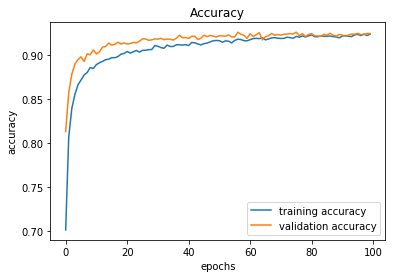

In [11]:
import matplotlib.pyplot as plt

plt.plot(training_stats.history['acc'], label='training accuracy')
plt.plot(training_stats.history['val_acc'], label='validation accuracy')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

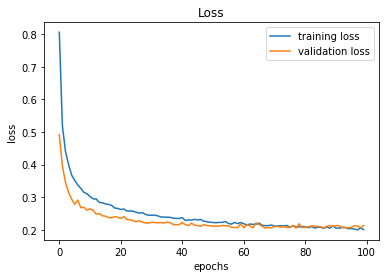

In [12]:
plt.plot(training_stats.history['loss'], label='training loss')
plt.plot(training_stats.history['val_loss'], label='validation loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

In [13]:
test_probs = model.predict(x_test)
loss = log_loss(y_test, test_probs)
test_preds = test_probs.argmax(axis=1)
y_test_classes = y_test.argmax(axis=1)
accuracy = accuracy_score(y_test_classes, test_preds)
print('Loss: %f' % loss)
print('Accuracy %f' % accuracy)

Loss: 0.189994
Accuracy 0.930100


In [14]:
label_names = ["T-shirt/top",  "Trouser",  "Pullover",  "Dress",  "Coat",
               "Sandal",  "Shirt",  "Sneaker",  "Bag",  "Ankle Boot"]

In [15]:
y_test_classes

array([0, 1, 2, ..., 8, 8, 1])

In [16]:
matrix = confusion_matrix(y_test_classes, test_preds)
conf = pd.DataFrame(data=matrix, index=label_names, columns=label_names)
total = conf.sum(axis=1)
conf['True Predicted'] = np.diag(matrix)
conf['False Predicted'] = total.sub(conf['True Predicted'])
conf['Total'] = total
conf = conf.append(conf.sum(axis=0).rename('Total'))
pd.concat({"Actual": pd.concat({"Predictions": conf}, axis=1)}, axis=0)

Predictions          ...                         
                   T-shirt/top Trouser  ...   False Predicted  Total
Actual T-shirt/top         909       1  ...                91   1000
       Trouser               0     994  ...                 6   1000
       Pullover             11       1  ...                86   1000
       Dress                13       2  ...                68   1000
       Coat                  0       0  ...                96   1000
       Sandal                0       0  ...                24   1000
       Shirt               106       3  ...               261   1000
       Sneaker               0       0  ...                25   1000
       Bag                   4       0  ...                13   1000
       Ankle Boot            0       0  ...                29   1000
       Total              1043    1001  ...               699  10000

[11 rows x 13 columns]

### jupyter-vim-plugin
Uncomment and run the cell below to enable vim bindings for this session.
Rather than loading it by default and permanently, I chose to enable manually for each session.
Cause I like vim, but maybe you don't

In [2]:
# %%javascript
# Jupyter.utils.load_extensions('vim_binding/vim_binding');